In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import yfinance as fix
fix.pdr_override()
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
import keras.layers as kl
from keras.models import Model
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import output_file, figure, show


In [2]:
class GetData:
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end

    # get stock data
    def get_stock_data(self):
        stock_data = pdr.get_data_yahoo(self.ticker, self.start, self.end)
        stock_data.to_csv("stock_data.csv")

In [3]:
data = GetData("AAPL", "2020-01-01", "2021-03-31")
data.get_stock_data()


[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data_ = pd.read_csv("stock_data.csv")

In [5]:
stock_data_.loc[:, 'Date'] = pd.to_datetime(stock_data_['Date'])
stock_data_.set_index('Date', inplace=True)

C:\Users\noahc\AppData\Local\Temp\ipykernel_10172\2140213931.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stock_data_.loc[:, 'Date'] = pd.to_datetime(stock_data_['Date'])


In [6]:
train_length = len(stock_data_.loc['2020-01-01':'2021-01-01'])
train_length

253

In [17]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt


class PreProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        self.stock_data = pd.read_csv("stock_data.csv")
    # wavelet transform and create autoencoder data
    def make_wavelet_train(self):
        train_data = []
        test_data = []
        log_train_data = []
        for i in range((len(self.stock_data)//10)*10 - 11):
            train = []
            log_ret = []
            for j in range(1, 6):
                x = np.array(self.stock_data.iloc[i: i + 11, j])
                (ca, cd) = pywt.dwt(x, "haar")
                cat = pywt.threshold(ca, np.std(ca), mode="soft")
                cdt = pywt.threshold(cd, np.std(cd), mode="soft")
                tx = pywt.idwt(cat, cdt, "haar")
                log = np.diff(np.log(tx))*100
                macd = np.mean(x[5:]) - np.mean(x)
                # ma = np.mean(x)
                sd = np.std(x)
                log_ret = np.append(log_ret, log)
                x_tech = np.append(macd*10, sd)
                train = np.append(train, x_tech)
            train_data.append(train)
            log_train_data.append(log_ret)
        trained = pd.DataFrame(train_data)
        trained.to_csv("preprocessing/indicators.csv")
        log_train = pd.DataFrame(log_train_data, index=None)
        log_train.to_csv("preprocessing/log_train.csv")
        # auto_train = pd.DataFrame(train_data[0:800])
        # auto_test = pd.DataFrame(train_data[801:1000])
        # auto_train.to_csv("auto_train.csv")
        # auto_test.to_csv("auto_test.csv")
        rbm_train = pd.DataFrame(log_train_data[0:int(self.split*self.feature_split*len(log_train_data))], index=None)       
        rbm_train.to_csv("preprocessing/rbm_train.csv")
        rbm_test = pd.DataFrame(log_train_data[int(self.split*self.feature_split*len(log_train_data))+1:
                                               int(self.feature_split*len(log_train_data))])
        rbm_test.to_csv("preprocessing/rbm_test.csv")
        for i in range((len(self.stock_data) // 10) * 10 - 11):
            y = 100*np.log(self.stock_data.iloc[i + 11, 5] / self.stock_data.iloc[i + 10, 5])
            test_data.append(y)
        test = pd.DataFrame(test_data)
        test.to_csv("preprocessing/test_data.csv")

    def make_test_data(self):
        test_stock = []
        # stock_data_test = pd.read_csv("stock_data_test.csv", index_col=0)

        for i in range((len(self.stock_data) // 10) * 10 - 11):
            l = self.stock_data.iloc[i+11, 5]
            test_stock.append(l)
            test = pd.DataFrame(test_stock)
            test.to_csv("preprocessing/test_stock.csv")

        stock_test_data = np.array(test_stock)[len(stock_data_.loc['2020-01-01':'2021-01-01'])+1:]
        stock = pd.DataFrame(stock_test_data, index=None)
        stock.to_csv("stock_data_test.csv")

        # print(train_data[1:5])
        # print(test_data[1:5])
        # plt.plot(train_data[1])
        # plt.show()

In [18]:
log_train_ = pd.read_csv("preprocessing/log_train.csv")
log_train_

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,50,51,52,53,54
0,0,0.000000,-0.186188,0.454837,0.705870,1.814062,2.078979,0.000000,1.052655,-0.037791,...,0.070120,0.000000,2.036332,0.866296,1.497646,0.907778,-0.986836,0.000000,1.052152,0.0
1,1,-0.110193,1.103322,0.000000,3.470460,0.105279,1.346693,0.658570,-0.803338,0.000000,...,0.433569,0.619777,2.774142,0.000000,1.797519,-0.422392,-0.437663,0.300296,1.612345,0.0
2,2,0.466723,0.693642,1.825257,2.072407,0.000000,1.057981,-0.049140,0.237780,0.000000,...,1.960829,1.010912,1.352058,1.048944,-1.056476,0.000000,1.600699,0.027009,-0.147149,0.0
3,3,-0.076761,3.396276,0.299054,1.148044,0.846675,-0.895004,0.000000,1.301454,0.000000,...,2.791919,0.000000,1.758290,-0.359479,-0.435376,0.237672,1.289284,0.000000,0.016051,0.0
4,4,1.905101,2.012894,0.000000,1.095334,-0.137456,0.280567,0.000000,0.950080,0.000000,...,1.229298,1.154278,-1.105296,0.000000,1.534502,0.137940,-0.020976,0.000000,0.667297,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,294,0.000000,-0.838181,-0.650395,2.112679,0.000000,-1.008821,0.000000,3.483237,-0.421824,...,-2.988708,2.480151,0.611675,0.121814,0.757376,0.933456,1.713488,0.000000,-3.835728,0.0
295,295,0.000000,-0.688727,0.379052,0.739597,0.000000,0.866390,1.703796,-0.921988,0.000000,...,2.575354,0.000000,0.806051,0.000000,2.710076,0.000000,-0.964341,-1.583524,-1.428779,0.0
296,296,-0.346401,1.961102,0.000000,-1.009270,0.000000,3.338871,-0.129805,-2.183204,-1.244066,...,0.751349,0.000000,0.895939,0.781357,1.791375,0.000000,-4.067842,0.000000,2.614820,0.0
297,297,0.392884,0.733002,0.000000,0.859942,1.717695,-0.928901,0.000000,-2.784259,0.000000,...,0.802042,0.000000,2.696830,0.000000,-0.981796,-1.531152,-0.449529,0.853731,0.277728,0.0


In [19]:
preprocess = PreProcessing(0.8, 0.25)
preprocess.make_wavelet_train()


In [20]:
preprocess.make_test_data()

In [27]:
class AutoEncoder:
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = Input(shape=(1, input_shape))

        encoded1 = Dense(encoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
        encoded2 = Dense(encoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        encoded3 = Dense(self.encoding_dim, activation="relu", activity_regularizer=regularizers.l2(0))(encoded2)
        decoded1 = Dense(decoded1_shape, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
        decoded2 = Dense(decoded2_shape, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
        decoded = Dense(input_shape, activation="sigmoid", activity_regularizer=regularizers.l2(0))(decoded2)

        autoencoder = Model(inputs=input_data, outputs=decoded)

        encoder = Model(input_data, encoded3)

        # Now train the model using data we already preprocessed
        autoencoder.compile(loss="mean_squared_error", optimizer="adam")
        train = pd.read_csv("preprocessing/rbm_train.csv", index_col=0)
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (len(ntrain), 1, 55))
        

        # print(train_data)
        # autoencoder.summary()
        autoencoder.fit(train_data, train_data, epochs=1000, batch_size = 4)

        encoder.save("models/encoder.h5")

        test = pd.read_csv("preprocessing/rbm_test.csv", index_col=0)
        ntest = np.array(test)
        test_data = np.reshape(ntest, (len(ntest), 1, 55))

        print(autoencoder.evaluate(test_data, test_data))
        # pred = np.reshape(ntest[1], (1, 1, 75))
        # print(encoder.predict(pred))

        log_train = pd.read_csv("preprocessing/log_train.csv", index_col=0)
        coded_train = []
        for i in range(len(log_train)):
            data = np.array(log_train.iloc[i, :])
            values = np.reshape(data, (1, 1, 55))
            coded = encoder.predict(values)
            shaped = np.reshape(coded, (20,))
            coded_train.append(shaped)

        train_coded = pd.DataFrame(coded_train)
        train_coded.to_csv("features/autoencoded_data.csv")


In [32]:
autoencoder = AutoEncoder(20)
autoencoder.build_train_model(55, 40, 30, 30, 40)

Epoch 1/1000
15/15 [==============================] - 1s 9ms/step - loss: 8.2944
Epoch 2/1000
15/15 [==============================] - 0s 9ms/step - loss: 8.2023
Epoch 3/1000
15/15 [==============================] - 0s 10ms/step - loss: 8.0967
Epoch 4/1000
15/15 [==============================] - 0s 10ms/step - loss: 7.9561
Epoch 5/1000
15/15 [==============================] - 0s 10ms/step - loss: 7.7944
Epoch 6/1000
15/15 [==============================] - 0s 9ms/step - loss: 7.6393
Epoch 7/1000
15/15 [==============================] - 0s 9ms/step - loss: 7.5244
Epoch 8/1000
15/15 [==============================] - 0s 10ms/step - loss: 7.4249
Epoch 9/1000
15/15 [==============================] - 0s 10ms/step - loss: 7.3457
Epoch 10/1000
15/15 [==============================] - 0s 10ms/step - loss: 7.2863
Epoch 11/1000
15/15 [==============================] - 0s 9ms/step - loss: 7.2494
Epoch 12/1000
15/15 [==============================] - 0s 10ms/step - loss: 7.2232
Epoch 13/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8484
Epoch 101/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8486
Epoch 102/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8482
Epoch 103/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8489
Epoch 104/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8505
Epoch 105/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8519
Epoch 106/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8478
Epoch 107/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8470
Epoch 108/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8453
Epoch 109/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8443
Epoch 110/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8436
Epoch 111/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8433
Epoch 112/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8290
Epoch 199/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8291
Epoch 200/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8289
Epoch 201/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8288
Epoch 202/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8287
Epoch 203/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8286
Epoch 204/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8286
Epoch 205/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8285
Epoch 206/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8285
Epoch 207/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8285
Epoch 208/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8285
Epoch 209/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8285
Epoch 210/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8326
Epoch 297/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8397
Epoch 298/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8457
Epoch 299/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8564
Epoch 300/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8551
Epoch 301/1000
15/15 [==============================] - 0s 8ms/step - loss: 6.8800
Epoch 302/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.9018
Epoch 303/1000
15/15 [==============================] - 0s 8ms/step - loss: 6.8933
Epoch 304/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8756
Epoch 305/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8636
Epoch 306/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8576
Epoch 307/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8475
Epoch 308/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8239
Epoch 395/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8240
Epoch 396/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8239
Epoch 397/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8239
Epoch 398/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8240
Epoch 399/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8239
Epoch 400/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8238
Epoch 401/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8239
Epoch 402/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8242
Epoch 403/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8242
Epoch 404/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8238
Epoch 405/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8244
Epoch 406/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8242
Epoch 493/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8242
Epoch 494/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8241
Epoch 495/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8242
Epoch 496/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8242
Epoch 497/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8242
Epoch 498/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8241
Epoch 499/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8241
Epoch 500/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8240
Epoch 501/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8240
Epoch 502/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8239
Epoch 503/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8240
Epoch 504/1000


15/15 [==============================] - 0s 9ms/step - loss: 6.8230
Epoch 591/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8231
Epoch 592/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8231
Epoch 593/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8228
Epoch 594/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8232
Epoch 595/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8231
Epoch 596/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8234
Epoch 597/1000
15/15 [==============================] - 0s 10ms/step - loss: 6.8235
Epoch 598/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8236
Epoch 599/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8237
Epoch 600/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8236
Epoch 601/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8231
Epoch 602/1000
1

15/15 [==============================] - 0s 9ms/step - loss: 6.8460
Epoch 689/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8447
Epoch 690/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8424
Epoch 691/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8417
Epoch 692/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8409
Epoch 693/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8403
Epoch 694/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8400
Epoch 695/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8396
Epoch 696/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8395
Epoch 697/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8396
Epoch 698/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8394
Epoch 699/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8393
Epoch 700/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8205
Epoch 787/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8204
Epoch 788/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8205
Epoch 789/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8209
Epoch 790/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8204
Epoch 791/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8205
Epoch 792/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8203
Epoch 793/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8198
Epoch 794/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8196
Epoch 795/1000
15/15 [==============================] - 0s 8ms/step - loss: 6.8195
Epoch 796/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8194
Epoch 797/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8191
Epoch 798/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8130
Epoch 885/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8131
Epoch 886/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8129
Epoch 887/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8128
Epoch 888/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8130
Epoch 889/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8128
Epoch 890/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8131
Epoch 891/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8127
Epoch 892/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8128
Epoch 893/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8129
Epoch 894/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8128
Epoch 895/1000
15/15 [==============================] - 0s 8ms/step - loss: 6.8129
Epoch 896/1000
15/1

15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 983/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8154
Epoch 984/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8153
Epoch 985/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8153
Epoch 986/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 987/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 988/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 989/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 990/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 991/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 992/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8152
Epoch 993/1000
15/15 [==============================] - 0s 9ms/step - loss: 6.8146
Epoch 994/1000
15/1

In [33]:
class DataProcessing:
    def __init__(self, split, feature_split):
        self.split = split
        self.feature_split = feature_split
        # self.train = pd.read_csv("train_data.csv", index_col=0)
        # print(train.tail())
        self.test = pd.read_csv("preprocessing/test_data.csv", index_col=0)
        # print(test.tail())
        self.test_stock = pd.read_csv("preprocessing/test_stock.csv", index_col=0)
        # self.auto_train = pd.read_csv("features/autoencoded_corrected_data.csv", index_col=0)
        self.auto_train = pd.read_csv("features/autoencoded_data.csv", index_col=0)
        # auto_train.drop([0, 14, 16], axis=1, inplace=True)
        # auto_train.to_csv("autoencoded_corrected_data.csv", index=None)

    def make_train_data(self):
        train_data = np.array(self.auto_train)[int(self.feature_split*len(self.auto_train))+1:
                                               int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_data = pd.DataFrame(train_data, index=None)
        train_data.to_csv("features/autoencoded_train_data.csv")

    def make_test_data(self):
        test_data = np.array(self.auto_train)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                                  self.feature_split*len(self.auto_train)+1):]
        test_data = pd.DataFrame(test_data, index=None)
        test_data.to_csv("features/autoencoded_test_data.csv")

    def make_train_y(self):
        train_y = np.array(self.test)[int(self.feature_split*len(self.auto_train))+1:
                                      int((1-self.feature_split)*self.split*len(self.auto_train))]
        train_y = pd.DataFrame(train_y, index=None)
        train_y.to_csv("features/autoencoded_train_y.csv")

    def make_test_y(self):
        test_y = np.array(self.test)[int((1-self.feature_split)*self.split*len(self.auto_train) +
                                         self.feature_split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y)
        test_y.to_csv("features/autoencoded_test_y.csv")

    def make_stock_train_y(self):
        test_y = np.array(self.test_stock)[int(self.feature_split*len(self.auto_train))+1:
                                           int((1-self.feature_split)*self.split*len(self.auto_train))]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_train_y.csv")

    def make_stock_test_y(self):
        test_y = np.array(self.test_stock)[int((1-self.feature_split)*self.split*len(self.auto_train))+1:]
        test_y = pd.DataFrame(test_y, index=None)
        test_y.to_csv("features/nn_stock_test_y.csv")







In [34]:
process = DataProcessing(0.8, 0.25)
process.make_test_data()
process.make_train_data()
process.make_train_y()
process.make_test_y()

In [35]:
class NeuralNetwork:
    def __init__(self, input_shape, stock_or_return):
        self.input_shape = input_shape
        self.stock_or_return = stock_or_return

    def make_train_model(self):
        input_data = kl.Input(shape=(1, self.input_shape))
        lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
        perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
        lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
        out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

        model = Model(input_data, out)
        model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

        # load data

        train = np.reshape(np.array(pd.read_csv("features/autoencoded_train_data.csv", index_col=0)),
                           (len(np.array(pd.read_csv("features/autoencoded_train_data.csv"))), 1, self.input_shape))
        train_y = np.array(pd.read_csv("features/autoencoded_train_y.csv", index_col=0))
        # train_stock = np.array(pd.read_csv("train_stock.csv"))

        # train model

        model.fit(train, train_y, epochs=2000)

        model.save("models/model.h5", overwrite=True, include_optimizer=True)

        test_x = np.reshape(np.array(pd.read_csv("features/autoencoded_test_data.csv", index_col=0)),
                            (len(np.array(pd.read_csv("features/autoencoded_test_data.csv"))), 1, self.input_shape))
        test_y = np.array(pd.read_csv("features/autoencoded_test_y.csv", index_col=0))
        # test_stock = np.array(pd.read_csv("test_stock.csv"))

        stock_data_test = np.array(pd.read_csv("stock_data_test.csv", index_col=0))

        print(model.evaluate(test_x, test_y))
        prediction_data = []
        stock_data = []
        for i in range(len(test_y)):
            prediction = (model.predict(np.reshape(test_x[i], (1, 1, self.input_shape))))
            prediction_data.append(np.reshape(prediction, (1,)))
            prediction_corrected = (prediction_data - np.mean(prediction_data))/np.std(prediction_data)
            stock_price = np.exp(np.reshape(prediction, (1,)))*stock_data_test[i]
            stock_data.append(stock_price[0])
        stock_data[:] = [i - (float(stock_data[0])-float(stock_data_test[0])) for i in stock_data]
        # stock_data = stock_data - stock_data[0]
        if self.stock_or_return:
            plt.plot(stock_data)
            plt.plot(stock_data_test)
            stock = pd.DataFrame(stock_data, index=None)
            stock.to_csv("sample_predictions/AAPL_predicted_prices.csv")
            stock_test = pd.DataFrame(stock_data_test, index=None)
            stock_test.to_csv("sample_predictions/AAPL_actual_prices.csv")
            # print(stock_data)
            plt.show()
        else:
            # plt.plot(prediction_corrected)
            plt.plot(prediction_data)
            # print(prediction_data)
            plt.plot(test_y)
            plt.show()



Epoch 1/2000
4/4 [==============================] - 4s 43ms/step - loss: 5.8027 - mse: 5.7919
Epoch 2/2000
4/4 [==============================] - 0s 39ms/step - loss: 5.8042 - mse: 5.7935
Epoch 3/2000
4/4 [==============================] - 0s 35ms/step - loss: 5.7845 - mse: 5.7738
Epoch 4/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.8013 - mse: 5.7906
Epoch 5/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7886 - mse: 5.7781
Epoch 6/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7873 - mse: 5.7768
Epoch 7/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7889 - mse: 5.7783
Epoch 8/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7713 - mse: 5.7608
Epoch 9/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.8010 - mse: 5.7906
Epoch 10/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.7969 - mse: 5.7867
Epoch 11/2000
4/4 [==============================] - 0s 31m

Epoch 84/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7757 - mse: 5.7673
Epoch 85/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7908 - mse: 5.7828
Epoch 86/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.8005 - mse: 5.7924
Epoch 87/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7823 - mse: 5.7743
Epoch 88/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.7597 - mse: 5.7515
Epoch 89/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7905 - mse: 5.7826
Epoch 90/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.7842 - mse: 5.7761
Epoch 91/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7855 - mse: 5.7774
Epoch 92/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.7774 - mse: 5.7695
Epoch 93/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.7787 - mse: 5.7706
Epoch 94/2000
4/4 [==============================]

4/4 [==============================] - 0s 30ms/step - loss: 5.7685 - mse: 5.7603
Epoch 170/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7798 - mse: 5.7718
Epoch 171/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7623 - mse: 5.7543
Epoch 172/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7902 - mse: 5.7823
Epoch 173/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7778 - mse: 5.7698
Epoch 174/2000
4/4 [==============================] - 0s 29ms/step - loss: 5.7820 - mse: 5.7740
Epoch 175/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.8152 - mse: 5.8070
Epoch 176/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7494 - mse: 5.7415
Epoch 177/2000
4/4 [==============================] - 0s 29ms/step - loss: 5.7687 - mse: 5.7605
Epoch 178/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7642 - mse: 5.7561
Epoch 179/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 34ms/step - loss: 5.7186 - mse: 5.7098
Epoch 255/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7667 - mse: 5.7580
Epoch 256/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7271 - mse: 5.7184
Epoch 257/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7454 - mse: 5.7366
Epoch 258/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.7054 - mse: 5.6966
Epoch 259/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.7324 - mse: 5.7234
Epoch 260/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.8095 - mse: 5.8007
Epoch 261/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.7131 - mse: 5.7044
Epoch 262/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.6988 - mse: 5.6899
Epoch 263/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.6899 - mse: 5.6808
Epoch 264/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 30ms/step - loss: 5.5979 - mse: 5.5873
Epoch 340/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.5964 - mse: 5.5863
Epoch 341/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.6069 - mse: 5.5966
Epoch 342/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.6261 - mse: 5.6158
Epoch 343/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.7132 - mse: 5.7030
Epoch 344/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.5584 - mse: 5.5475
Epoch 345/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.6587 - mse: 5.6482
Epoch 346/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.6347 - mse: 5.6241
Epoch 347/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.7103 - mse: 5.6999
Epoch 348/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.5932 - mse: 5.5824
Epoch 349/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 32ms/step - loss: 5.6420 - mse: 5.6304
Epoch 425/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.6130 - mse: 5.6010
Epoch 426/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.5638 - mse: 5.5520
Epoch 427/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.6379 - mse: 5.6260
Epoch 428/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.6115 - mse: 5.6000
Epoch 429/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.5905 - mse: 5.5792
Epoch 430/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.5413 - mse: 5.5296
Epoch 431/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.4749 - mse: 5.4636
Epoch 432/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.6317 - mse: 5.6205
Epoch 433/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.5985 - mse: 5.5874
Epoch 434/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 31ms/step - loss: 5.4372 - mse: 5.4251
Epoch 510/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3886 - mse: 5.3763
Epoch 511/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.5655 - mse: 5.5533
Epoch 512/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.6067 - mse: 5.5943
Epoch 513/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3015 - mse: 5.2893
Epoch 514/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.4487 - mse: 5.4359
Epoch 515/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.5442 - mse: 5.5318
Epoch 516/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.4307 - mse: 5.4178
Epoch 517/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.4333 - mse: 5.4210
Epoch 518/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.6273 - mse: 5.6151
Epoch 519/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 35ms/step - loss: 5.3400 - mse: 5.3271
Epoch 595/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.4037 - mse: 5.3910
Epoch 596/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3946 - mse: 5.3814
Epoch 597/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.2974 - mse: 5.2841
Epoch 598/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2961 - mse: 5.2827
Epoch 599/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.2619 - mse: 5.2489
Epoch 600/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3886 - mse: 5.3758
Epoch 601/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.3572 - mse: 5.3441
Epoch 602/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.5024 - mse: 5.4897
Epoch 603/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3125 - mse: 5.2991
Epoch 604/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 31ms/step - loss: 5.4280 - mse: 5.4143
Epoch 680/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.4608 - mse: 5.4479
Epoch 681/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.4654 - mse: 5.4515
Epoch 682/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2559 - mse: 5.2425
Epoch 683/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.3513 - mse: 5.3379
Epoch 684/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3793 - mse: 5.3657
Epoch 685/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2313 - mse: 5.2172
Epoch 686/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3150 - mse: 5.3015
Epoch 687/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2579 - mse: 5.2441
Epoch 688/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.3428 - mse: 5.3288
Epoch 689/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 31ms/step - loss: 5.3475 - mse: 5.3343
Epoch 765/2000
4/4 [==============================] - 0s 29ms/step - loss: 5.3164 - mse: 5.3035
Epoch 766/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3208 - mse: 5.3068
Epoch 767/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3390 - mse: 5.3261
Epoch 768/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2225 - mse: 5.2093
Epoch 769/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3148 - mse: 5.3016
Epoch 770/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2727 - mse: 5.2594
Epoch 771/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1699 - mse: 5.1562
Epoch 772/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.1847 - mse: 5.1715
Epoch 773/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2642 - mse: 5.2509
Epoch 774/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 31ms/step - loss: 5.3049 - mse: 5.2915
Epoch 850/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2340 - mse: 5.2207
Epoch 851/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.2991 - mse: 5.2857
Epoch 852/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.1993 - mse: 5.1858
Epoch 853/2000
4/4 [==============================] - 0s 35ms/step - loss: 5.2941 - mse: 5.2809
Epoch 854/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3185 - mse: 5.3051
Epoch 855/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.4376 - mse: 5.4237
Epoch 856/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2309 - mse: 5.2174
Epoch 857/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.0139 - mse: 5.0003
Epoch 858/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.4427 - mse: 5.4296
Epoch 859/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 30ms/step - loss: 5.1965 - mse: 5.1826
Epoch 935/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1720 - mse: 5.1581
Epoch 936/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3325 - mse: 5.3185
Epoch 937/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1791 - mse: 5.1651
Epoch 938/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.4469 - mse: 5.4334
Epoch 939/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1607 - mse: 5.1470
Epoch 940/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.4231 - mse: 5.4093
Epoch 941/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3774 - mse: 5.3632
Epoch 942/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3840 - mse: 5.3702
Epoch 943/2000
4/4 [==============================] - 0s 29ms/step - loss: 5.2385 - mse: 5.2240
Epoch 944/2000
4/4 [==============================] - 0

4/4 [==============================] - 0s 31ms/step - loss: 5.3163 - mse: 5.3028
Epoch 1020/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3032 - mse: 5.2895
Epoch 1021/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1501 - mse: 5.1368
Epoch 1022/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.4089 - mse: 5.3953
Epoch 1023/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1976 - mse: 5.1838
Epoch 1024/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.0954 - mse: 5.0815
Epoch 1025/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1082 - mse: 5.0942
Epoch 1026/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2372 - mse: 5.2235
Epoch 1027/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1666 - mse: 5.1527
Epoch 1028/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.0904 - mse: 5.0771
Epoch 1029/2000
4/4 [=========================

4/4 [==============================] - 0s 35ms/step - loss: 5.0802 - mse: 5.0666
Epoch 1104/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.2700 - mse: 5.2563
Epoch 1105/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.2032 - mse: 5.1909
Epoch 1106/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.4374 - mse: 5.4240
Epoch 1107/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2775 - mse: 5.2636
Epoch 1108/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2190 - mse: 5.2065
Epoch 1109/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.2316 - mse: 5.2180
Epoch 1110/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1841 - mse: 5.1704
Epoch 1111/2000
4/4 [==============================] - 0s 31ms/step - loss: 4.9442 - mse: 4.9306
Epoch 1112/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1252 - mse: 5.1111
Epoch 1113/2000
4/4 [=========================

4/4 [==============================] - 0s 32ms/step - loss: 5.2315 - mse: 5.2181
Epoch 1188/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0507 - mse: 5.0371
Epoch 1189/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3482 - mse: 5.3347
Epoch 1190/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1135 - mse: 5.1006
Epoch 1191/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2386 - mse: 5.2251
Epoch 1192/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1108 - mse: 5.0966
Epoch 1193/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1772 - mse: 5.1637
Epoch 1194/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3371 - mse: 5.3236
Epoch 1195/2000
4/4 [==============================] - 0s 31ms/step - loss: 4.9476 - mse: 4.9344
Epoch 1196/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3609 - mse: 5.3477
Epoch 1197/2000
4/4 [=========================

4/4 [==============================] - 0s 32ms/step - loss: 5.1224 - mse: 5.1087
Epoch 1272/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1653 - mse: 5.1522
Epoch 1273/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.4249 - mse: 5.4116
Epoch 1274/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.4183 - mse: 5.4049
Epoch 1275/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3566 - mse: 5.3428
Epoch 1276/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0831 - mse: 5.0690
Epoch 1277/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2064 - mse: 5.1929
Epoch 1278/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3366 - mse: 5.3237
Epoch 1279/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1715 - mse: 5.1572
Epoch 1280/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.2938 - mse: 5.2796
Epoch 1281/2000
4/4 [=========================

4/4 [==============================] - 0s 33ms/step - loss: 5.0856 - mse: 5.0724
Epoch 1356/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.2837 - mse: 5.2703
Epoch 1357/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1003 - mse: 5.0856
Epoch 1358/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.0819 - mse: 5.0684
Epoch 1359/2000
4/4 [==============================] - 0s 33ms/step - loss: 4.9870 - mse: 4.9728
Epoch 1360/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.2024 - mse: 5.1885
Epoch 1361/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.1212 - mse: 5.1072
Epoch 1362/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.1080 - mse: 5.0945
Epoch 1363/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.4843 - mse: 5.4710
Epoch 1364/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1006 - mse: 5.0875
Epoch 1365/2000
4/4 [=========================

4/4 [==============================] - 0s 32ms/step - loss: 5.1303 - mse: 5.1171
Epoch 1440/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1464 - mse: 5.1326
Epoch 1441/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0021 - mse: 4.9883
Epoch 1442/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3398 - mse: 5.3262
Epoch 1443/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.2200 - mse: 5.2061
Epoch 1444/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0732 - mse: 5.0596
Epoch 1445/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.0907 - mse: 5.0780
Epoch 1446/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3190 - mse: 5.3057
Epoch 1447/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2206 - mse: 5.2074
Epoch 1448/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0892 - mse: 5.0760
Epoch 1449/2000
4/4 [=========================

4/4 [==============================] - 0s 31ms/step - loss: 5.1025 - mse: 5.0890
Epoch 1524/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.1913 - mse: 5.1779
Epoch 1525/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0413 - mse: 5.0275
Epoch 1526/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.0642 - mse: 5.0507
Epoch 1527/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1787 - mse: 5.1649
Epoch 1528/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0501 - mse: 5.0362
Epoch 1529/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.4339 - mse: 5.4204
Epoch 1530/2000
4/4 [==============================] - 0s 31ms/step - loss: 4.9348 - mse: 4.9205
Epoch 1531/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.1965 - mse: 5.1827
Epoch 1532/2000
4/4 [==============================] - 0s 33ms/step - loss: 4.9288 - mse: 4.9161
Epoch 1533/2000
4/4 [=========================

4/4 [==============================] - 0s 30ms/step - loss: 5.2656 - mse: 5.2522
Epoch 1608/2000
4/4 [==============================] - 0s 30ms/step - loss: 4.9157 - mse: 4.9015
Epoch 1609/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1299 - mse: 5.1160
Epoch 1610/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1739 - mse: 5.1606
Epoch 1611/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1731 - mse: 5.1594
Epoch 1612/2000
4/4 [==============================] - 0s 31ms/step - loss: 4.9830 - mse: 4.9688
Epoch 1613/2000
4/4 [==============================] - 0s 31ms/step - loss: 4.9188 - mse: 4.9056
Epoch 1614/2000
4/4 [==============================] - 0s 34ms/step - loss: 4.9438 - mse: 4.9297
Epoch 1615/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.3318 - mse: 5.3180
Epoch 1616/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.3037 - mse: 5.2910
Epoch 1617/2000
4/4 [=========================

4/4 [==============================] - 0s 32ms/step - loss: 5.2249 - mse: 5.2110
Epoch 1692/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2429 - mse: 5.2297
Epoch 1693/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.0948 - mse: 5.0814
Epoch 1694/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3222 - mse: 5.3093
Epoch 1695/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.0428 - mse: 5.0298
Epoch 1696/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.1895 - mse: 5.1764
Epoch 1697/2000
4/4 [==============================] - 0s 31ms/step - loss: 4.9535 - mse: 4.9409
Epoch 1698/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.3235 - mse: 5.3102
Epoch 1699/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.0413 - mse: 5.0276
Epoch 1700/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0275 - mse: 5.0142
Epoch 1701/2000
4/4 [=========================

4/4 [==============================] - 0s 32ms/step - loss: 5.4434 - mse: 5.4305
Epoch 1776/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2156 - mse: 5.2023
Epoch 1777/2000
4/4 [==============================] - 0s 32ms/step - loss: 4.9882 - mse: 4.9746
Epoch 1778/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.0638 - mse: 5.0508
Epoch 1779/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.2217 - mse: 5.2082
Epoch 1780/2000
4/4 [==============================] - 0s 37ms/step - loss: 4.9175 - mse: 4.9042
Epoch 1781/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.3288 - mse: 5.3154
Epoch 1782/2000
4/4 [==============================] - 0s 30ms/step - loss: 5.0473 - mse: 5.0336
Epoch 1783/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.0095 - mse: 4.9956
Epoch 1784/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0880 - mse: 5.0740
Epoch 1785/2000
4/4 [=========================

4/4 [==============================] - 0s 36ms/step - loss: 4.9774 - mse: 4.9635
Epoch 1860/2000
4/4 [==============================] - 0s 36ms/step - loss: 5.2786 - mse: 5.2647
Epoch 1861/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.0320 - mse: 5.0182
Epoch 1862/2000
4/4 [==============================] - 0s 36ms/step - loss: 5.0730 - mse: 5.0598
Epoch 1863/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.1425 - mse: 5.1287
Epoch 1864/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.2042 - mse: 5.1904
Epoch 1865/2000
4/4 [==============================] - 0s 34ms/step - loss: 5.1208 - mse: 5.1078
Epoch 1866/2000
4/4 [==============================] - 0s 35ms/step - loss: 4.9802 - mse: 4.9662
Epoch 1867/2000
4/4 [==============================] - 0s 34ms/step - loss: 4.8935 - mse: 4.8798
Epoch 1868/2000
4/4 [==============================] - 0s 35ms/step - loss: 5.2813 - mse: 5.2680
Epoch 1869/2000
4/4 [=========================

4/4 [==============================] - 0s 32ms/step - loss: 4.9207 - mse: 4.9066
Epoch 1944/2000
4/4 [==============================] - 0s 33ms/step - loss: 4.9723 - mse: 4.9579
Epoch 1945/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0978 - mse: 5.0844
Epoch 1946/2000
4/4 [==============================] - 0s 32ms/step - loss: 5.0499 - mse: 5.0359
Epoch 1947/2000
4/4 [==============================] - 0s 30ms/step - loss: 4.9152 - mse: 4.9013
Epoch 1948/2000
4/4 [==============================] - 0s 31ms/step - loss: 5.2760 - mse: 5.2630
Epoch 1949/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.1244 - mse: 5.1112
Epoch 1950/2000
4/4 [==============================] - 0s 34ms/step - loss: 4.9595 - mse: 4.9460
Epoch 1951/2000
4/4 [==============================] - 0s 33ms/step - loss: 5.1756 - mse: 5.1626
Epoch 1952/2000
4/4 [==============================] - 0s 30ms/step - loss: 4.9037 - mse: 4.8903
Epoch 1953/2000
4/4 [=========================

C:\Users\noahc\AppData\Local\Temp\ipykernel_10172\1244061734.py:44: RuntimeWarning: invalid value encountered in divide
  prediction_corrected = (prediction_data - np.mean(prediction_data))/np.std(prediction_data)


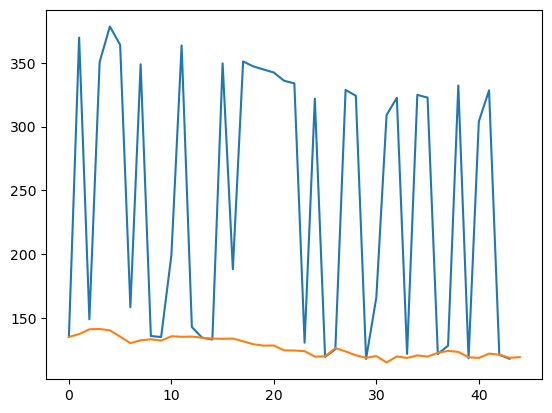

In [38]:
model = NeuralNetwork(20, True)
model.make_train_model()

In [39]:
import tensorflow as tf
from keras.models import Model
import keras.layers as kl
import keras as kr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error


def nnmodel(epochs, regularizer1, regularizer2):

    train_data = np.array(pd.read_csv("60_return_forex/encoded_return_train_data.csv", index_col=0))
    # length = len(train_data)
    train_data = np.reshape(train_data, (len(train_data), 20))
    print(np.shape(train_data))
    test_data = np.array(pd.read_csv("60_return_forex/encoded_return_test_data.csv", index_col=0))
    test_data = np.reshape(test_data, (len(test_data), 20))
    train_y = np.array(pd.read_csv("forex_y/log_train_y.csv", index_col=0))
    test_y = np.array(pd.read_csv("forex_y/log_test_y.csv", index_col=0))
    price = np.array(pd.read_csv("forex_y/test_price.csv", index_col=0))

    model = kr.models.Sequential()
    # model.add(kl.Dense(50, activation="sigmoid", activity_regularizer=kr.regularizers.l2(0)))
    model.add(kl.Dense(20, input_dim=20, activation="tanh", activity_regularizer=kr.regularizers.l2(regularizer1)))
    model.add(kl.Dense(20, activation="tanh", activity_regularizer=kr.regularizers.l2(regularizer2)))
    # model.add(kl.Dense(100))
    model.add(kl.Dense(1))

    model.compile(optimizer="sgd", loss="mean_squared_error")
    model.fit(train_data, train_y, epochs=epochs)
    model.save("models/final_model.h5")
    predicted_data = []
    predicted_price = []
    for i in range(len(test_data)):
        prediction = model.predict(np.reshape(test_data[i], (1, 20)))
        predicted_data.append(prediction)
        price_pred = np.exp(prediction)*price[i]
        predicted_price.append(price_pred)
        # print(test_data[i])

    # print(model.evaluate(test_data, test_y))
    pd.DataFrame(np.reshape(predicted_price, (len(predicted_price, )))).to_csv("60_return_forex/predicted_price.csv")
    pd.DataFrame(price).to_csv("60_return_forex/price.csv")

    plt.figure(1)
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(predicted_data)), np.reshape(test_y, (len(test_y))),
             np.reshape(predicted_data, (len(predicted_data))))
    plt.title("Prediction vs Actual")
    plt.ylabel("Log Return")

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(predicted_price)), np.reshape(price, (len(price))),
             np.reshape(predicted_price, (len(predicted_price))))
    plt.xlabel("Time stamp")
    plt.ylabel("Market Price")
    plt.show()

    price_r_score = r2_score(np.reshape(predicted_price, (len(predicted_price))), price)
    return_r_score = r2_score(np.reshape(predicted_data, (len(predicted_data))), test_y)
    price_mse = mean_squared_error(np.reshape(predicted_price, (len(predicted_price))), price)
    return_mse = mean_squared_error(np.reshape(predicted_data, (len(predicted_data))), test_y)

    print(f"Regularizer for 1: {regularizer1} \nRegularizer for 2: {regularizer2} \nEpochs: {epochs}")
    print(f"Predicted Price r^2 value: {price_r_score} \nPredicted return r^2 value: {return_r_score}"
          f"\nPredict Price MSE: {price_mse} \nPredicted Return MSE: {return_mse}")
    dataset = []
    values = np.array([regularizer1, regularizer2, epochs, price_r_score, return_r_score, price_mse, return_mse])
    dataset.append(values)
    dataset = pd.DataFrame(dataset, columns=["regularizer1", "regularizer2", "epochs", "price_r_score", "return_r_score", "price_mse", "return_mse"])
    # print(dataset)
    accuracy = []
    for i in range(len(price)-1):
        acc = 100 - (np.abs(predicted_price[i] - price[i+1]))/price[i+1] * 100
        accuracy.append(acc)
    average = np.mean(accuracy)
    std = np.std(accuracy)
    ret_acc = []
    for i in range(len(test_y)-1):
        if test_y[i] != 0:
            acc = 100 - (np.abs(predicted_data[i] - test_y[i]))/test_y[i] * 100
            ret_acc.append(acc)
    ret_avg = np.mean(ret_acc)
    ret_std = np.std(ret_acc)
    pd.DataFrame(np.reshape(ret_acc, (len(ret_acc, )))).to_csv("60_return_forex/ret_acc.csv")
    prediction = np.exp(model.predict(np.reshape(test_data[-2], (1, 20))))*price[-2]
    print(prediction)

    return dataset, average, std


In [40]:
dataset, average, std = nnmodel(500, 0.05, 0.01)
print(f"Price Accuracy Average = {average} \nPrice Accuracy Standard Deviation = {std}")



FileNotFoundError: [Errno 2] No such file or directory: '60_return_forex/encoded_return_train_data.csv'